## **Импорт базовых библиотек**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **Обработка датасета с новостями эмитентов с помощью эмбеддингов**


In [2]:
all_news = pd.read_csv('all_news.csv')
all_news.head()

,Unnamed: 0,Date,Company,Header,Full_news
0,2829,2024-12-23,magnit,Приобретение подконтрольной эмитенту организац...,Сообщение о существенном факте\nо приобретении...
1,2828,2024-12-20,positiv,Совершение эмитентом существенной сделки,Совершение эмитентом существенной сделки\n\n1....
2,2827,2024-12-20,lukoil,Проведение заседания совета директоров (наблюд...,СООБЩЕНИЕ О СУЩЕСТВЕННОМ ФАКТЕ\n О ПРОВЕДЕНИИ ...
3,2826,2024-12-19,positiv,Решения единственного акционера (участника),Решения единственного акционера (участника)\n\...
4,2825,2024-12-19,magnit,"Выплаченные доходы или иные выплаты, причитающ...",Сообщение\nо выплаченных доходах по ценным бум...


**Применим модель для перевода новостей из естественного языка в эмбеддинги**


In [4]:
!pip install torch
!pip install transformers bitsandbytes>=0.39.0 accelerate sentencepiece onnx -q
import torch
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

def get_bert_embedding(text):

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # Перемещаем результат обратно на CPU

all_news["embedding"] = all_news["Full_news"].apply(get_bert_embedding)
all_news.head()

,Unnamed: 0,Date,Company,Header,Full_news,embedding
0,2829,2024-12-23,magnit,Приобретение подконтрольной эмитенту организац...,Сообщение о существенном факте\nо приобретении...,"[0.5406759, -0.7683334, -0.88949126, -0.608708..."
1,2828,2024-12-20,positiv,Совершение эмитентом существенной сделки,Совершение эмитентом существенной сделки\n\n1....,"[-0.11709082, -0.23781498, -0.7659202, -0.7301..."
2,2827,2024-12-20,lukoil,Проведение заседания совета директоров (наблюд...,СООБЩЕНИЕ О СУЩЕСТВЕННОМ ФАКТЕ\n О ПРОВЕДЕНИИ ...,"[0.69580555, 0.10071276, 0.010414033, -0.02786..."
3,2826,2024-12-19,positiv,Решения единственного акционера (участника),Решения единственного акционера (участника)\n\...,"[-0.0025721714, -0.48915774, -0.5681367, -0.30..."
4,2825,2024-12-19,magnit,"Выплаченные доходы или иные выплаты, причитающ...",Сообщение\nо выплаченных доходах по ценным бум...,"[0.4422948, -0.29075974, -0.67116416, -0.49825..."


## **Объединим по дате выхода новости датасет с эмбеддингами и данные по котировкам акций**


In [5]:
all_stocks = pd.read_csv('all_stocks.csv')
all_merged = pd.merge(all_news, all_stocks, on = ['Date', 'Company'], how='outer')
all_merged['Date'] = pd.to_datetime(all_merged['Date'])
all_merged = all_merged.sort_values(by = 'Date', ascending = False)
all_merged.index = range(len(all_merged))
all_merged['Day'] = all_merged['Date'].dt.day_name()
all_merged = all_merged[['Date', 'Day', 'Company', 'Header', 'embedding', 'Цена', 'Откр.', 'Макс.', 'Мин.', 'Объём', 'Изм. %']]
all_merged['Date'] = (pd.to_datetime(all_merged['Date']))
all_merged.to_csv('all_merged.csv')
all_merged.head()

,Date,Day,Company,Header,embedding,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
0,2024-12-24,Tuesday,sber,NaN,NaN,264.34,264.94,266.62,261.03,"83,81M",-0.21
1,2024-12-24,Tuesday,positiv,NaN,NaN,1901.00,2019.00,2011.40,1891.00,"1,08M",-5.73
2,2024-12-24,Tuesday,nlmk,NaN,NaN,133.66,135.00,136.10,131.46,"9,97M",-0.33
3,2024-12-24,Tuesday,magnit,NaN,NaN,4945.50,4984.50,4984.50,4872.50,"504,40K",-0.77
4,2024-12-24,Tuesday,lukoil,NaN,NaN,6833.00,6919.00,6959.50,6825.00,"724,13K",-1.24


**Добавим колонки с логарифмическими доходностями цен акций на лагах в 1, 2 и 3 дня**

In [6]:
final_df = pd.DataFrame()
for company in all_merged['Company'].unique():
    company_df = all_merged[all_merged['Company'] == f'{company}'].copy()
    company_df['Лаг 3 дня %'] = (np.log(company_df['Цена'].shift(3) / company_df['Цена'])) * 100
    company_df['Лаг 2 дня %'] = (np.log(company_df['Цена'].shift(2) / company_df['Цена'])) * 100
    company_df['Лаг 1 день %'] = np.log(company_df['Цена'].shift(1) / company_df['Цена']) * 100
    final_df = pd.concat([final_df, company_df], ignore_index=True)
final_df.to_csv('final_df.csv')
final_df.dropna(inplace = True)
final_df.head()

,Date,Day,Company,Header,embedding,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Лаг 3 дня %,Лаг 2 дня %,Лаг 1 день %
29,2024-11-13,Wednesday,sber,"События (действия), оказывающие, по мнению эми...","[0.06433047, -0.49894887, -0.63283694, -0.5739...",254.70,255.29,258.96,254.05,"44,54M",-0.42,-2.375862,-0.499873,-2.054731
30,2024-11-12,Tuesday,sber,"События (действия), оказывающие, по мнению эми...","[0.03695213, -0.59659564, -0.7055809, -0.46222...",255.77,259.99,260.70,255.27,"40,93M",-1.90,-0.919095,-2.473953,-0.419222
31,2024-11-11,Monday,sber,Завершение размещения ценных бумаг Присвоение ...,"[0.47232103, -0.30909604, -0.33422807, -0.3731...",260.73,257.99,261.30,256.49,"67,85M",1.86,-4.394632,-2.339901,-1.920679
32,2024-11-08,Friday,sber,Решения совета директоров (наблюдательного сов...,"[-0.07067554, 0.084975354, -0.38239866, -0.098...",255.98,251.50,255.99,250.50,"58,09M",2.01,-0.501293,-0.082071,1.838607
33,2024-11-07,Thursday,sber,Включение эмиссионных ценных бумаг эмитента в ...,"[0.7027978, -0.42123142, -0.5912772, -0.440670...",250.93,243.26,251.00,242.16,"44,43M",3.01,1.910459,3.831137,1.992530


## **Удалим все наблюдения где абсолютное изменение логарифмической доходности на лаге в 1 день было больше 10%. Это скорее всего событие, вызваное не новостями эмитентов, а макроэкономическими шоками. Посмотрим, в какие дни они произошли**

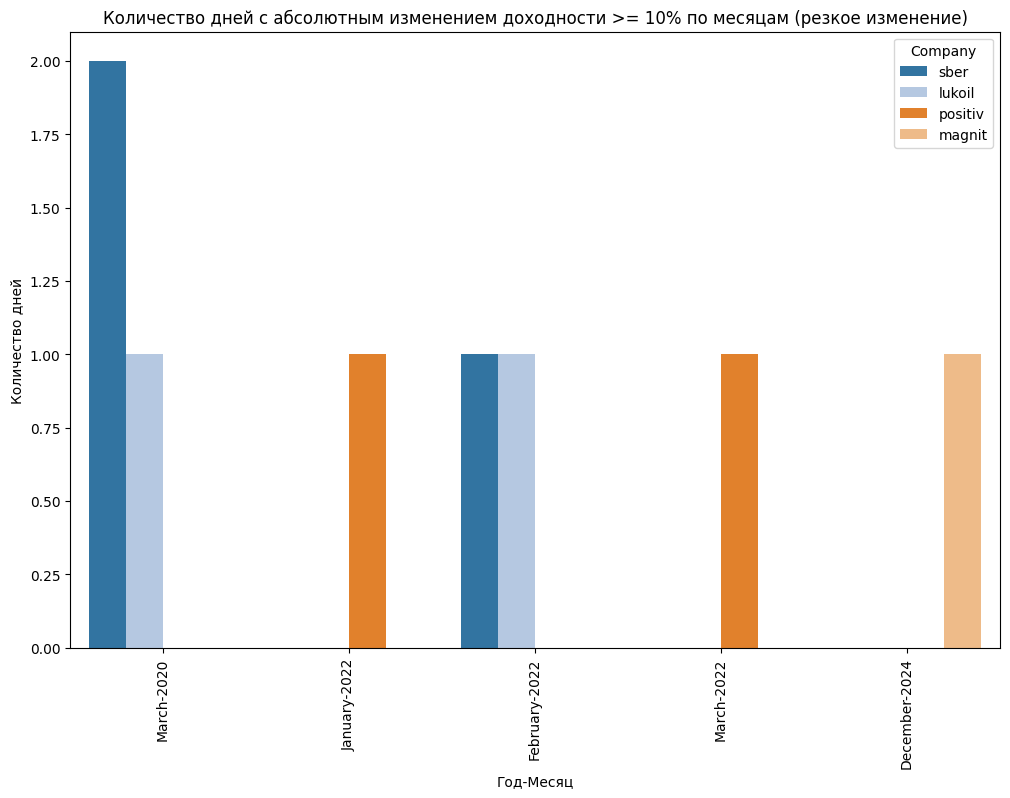

In [7]:
over_10 = final_df[abs(final_df['Лаг 1 день %']) >= 10].copy()
over_10['year_month_str'] = over_10['Date'].dt.strftime('%B-%Y')
over_10 = over_10.sort_values(by = 'Date')


plt.figure(figsize = (12,8));
sns.countplot(data = over_10,  x = 'year_month_str', hue = 'Company', palette = 'tab20');
plt.title('Количество дней с абсолютным изменением доходности >= 10% по месяцам (резкое изменение)')
plt.xlabel('Год-Месяц')
plt.ylabel('Количество дней')
plt.xticks(rotation = 90);

**Действительно, сильные выбросы в логарифмических доходностях вызваны не новостями эмитентов, а глобальными событиями, такими как пандемия коронавируса в марте 2020, наложение санкций в начале 2022 и установление высокой ключевой ставки в рамках проведения жесткой денежно-кредитной политики Центробанка в декабре 2024 года**

In [9]:
final_df = final_df[abs(final_df['Лаг 1 день %']) < 10]

## **Перевод эмбеддингов в массив numpy**

In [10]:
embeddings = np.array(final_df['embedding'].tolist())  # Преобразуем список эмбеддингов в массив numpy
df_embeddings = pd.DataFrame(embeddings)
df_embeddings.columns = [f'emb_{i}' for i in range(df_embeddings.shape[1])]
df_embeddings.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_302,emb_303,emb_304,emb_305,emb_306,emb_307,emb_308,emb_309,emb_310,emb_311
0,0.064330,-0.498949,-0.632837,-0.573905,-0.269392,0.557923,-0.226986,-0.675809,0.275286,1.215616,...,0.528213,0.523044,-0.186555,0.443646,-0.635937,0.353924,0.389553,0.387762,0.543400,-0.789982
1,0.036952,-0.596596,-0.705581,-0.462228,-0.100700,0.279106,-0.204765,-0.813799,0.448291,1.201431,...,0.472447,0.395335,-0.152724,0.485964,-0.604598,0.271844,0.357001,0.211568,0.477666,-0.608887
2,0.472321,-0.309096,-0.334228,-0.373149,0.087259,0.082579,0.198904,-0.396241,0.341361,0.931698,...,0.612485,0.548495,-0.509684,0.609152,-0.594624,0.010197,0.166807,0.041005,0.739752,-0.612903
3,-0.070676,0.084975,-0.382399,-0.098793,-0.415218,0.639691,0.069984,-1.012657,0.481872,1.064607,...,0.572723,0.583147,-0.148287,0.304619,-0.849141,0.122105,-0.243366,0.121756,0.596090,-0.487069
4,0.702798,-0.421231,-0.591277,-0.440671,0.383604,-0.045919,0.106735,-0.543156,0.014663,0.905846,...,0.180293,0.433918,-0.726971,0.593498,-0.498514,0.282910,0.291302,0.012194,0.612656,-0.631146


**Добавление категориальных признаков - названий компаний**

In [11]:
categor_df = pd.get_dummies(data = final_df, columns = ['Company'], drop_first = False)
categorial = categor_df[['Company_lukoil', 'Company_magnit',	'Company_nlmk',	'Company_positiv',	'Company_sber']].reset_index().drop('index', axis = 1)
categorial = categorial[['Company_lukoil', 'Company_magnit',	'Company_nlmk',	'Company_positiv',	'Company_sber']].astype(int)
categorial.head()

,Company_lukoil,Company_magnit,Company_nlmk,Company_positiv,Company_sber
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


**Получим массив регрессоров, состоящий из эмбеддингов и названий компаний**

In [12]:
regressor = df_embeddings.copy()
regressor[['Company_lukoil', 'Company_magnit',	'Company_nlmk',	'Company_positiv',	'Company_sber']] = categorial
regressor.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_307,emb_308,emb_309,emb_310,emb_311,Company_lukoil,Company_magnit,Company_nlmk,Company_positiv,Company_sber
0,0.064330,-0.498949,-0.632837,-0.573905,-0.269392,0.557923,-0.226986,-0.675809,0.275286,1.215616,...,0.353924,0.389553,0.387762,0.543400,-0.789982,0,0,0,0,1
1,0.036952,-0.596596,-0.705581,-0.462228,-0.100700,0.279106,-0.204765,-0.813799,0.448291,1.201431,...,0.271844,0.357001,0.211568,0.477666,-0.608887,0,0,0,0,1
2,0.472321,-0.309096,-0.334228,-0.373149,0.087259,0.082579,0.198904,-0.396241,0.341361,0.931698,...,0.010197,0.166807,0.041005,0.739752,-0.612903,0,0,0,0,1
3,-0.070676,0.084975,-0.382399,-0.098793,-0.415218,0.639691,0.069984,-1.012657,0.481872,1.064607,...,0.122105,-0.243366,0.121756,0.596090,-0.487069,0,0,0,0,1
4,0.702798,-0.421231,-0.591277,-0.440671,0.383604,-0.045919,0.106735,-0.543156,0.014663,0.905846,...,0.282910,0.291302,0.012194,0.612656,-0.631146,0,0,0,0,1


## **Применение моделей машинного обучения для предсказания изменений логарифмических доходностей цен акций на основе новостного сентимента**


**Входные данные:**



Регрессоры - набор из эмбеддингов и принадлежности к компании для каждого наблюдения



Регрессант - изменение логарифмической доходности с лагом 1 день

Тестовая выборка - 20% от всего набора новостей


In [13]:
from sklearn.model_selection import train_test_split
X = regressor
y = final_df['Лаг 1 день %']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Применение моделей RandomForest, SupportVectorMachines, GradientBoosting, XGBoost, LightGBM**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

models = {
    "Random Forest": RandomForestRegressor(n_estimators=150,
                                         max_depth=10,
                                         random_state=42,
                                         n_jobs=-1),

    "Support Vector": make_pipeline(StandardScaler(with_mean=False),
                                 SVR(kernel='rbf', C=1.0, epsilon=0.1)),

    "Gradient Boosting": GradientBoostingRegressor(n_estimators=150,
                                                 learning_rate=0.1,
                                                 max_depth=5,
                                                 random_state=42),

    "XGBoost": XGBRegressor(n_estimators=150,
                           learning_rate=0.1,
                           max_depth=5,
                           random_state=42,
                           n_jobs=-1),

    "LightGBM": LGBMRegressor(n_estimators=150,
                             learning_rate=0.1,
                             max_depth=5,
                             random_state=42,
                             n_jobs=-1)
}

print("Результаты кросс-валидации (R2 score):")
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train,
                            cv=5, scoring='r2', n_jobs=-1)
    cv_results[name] = scores.mean()
    print(f"{name}: {scores.mean():.3f} ± {scores.std():.3f}")


print("\nОценка на тестовом наборе:")
test_results = []
for name, model in models.items():

    model.fit(X_train, y_train)


    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_test)
    std_test = np.std(y_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_pred_train)
    std_train = np.std(y_train)
    test_results.append({
        'Model': name,
        'mse_test': mse_test,
        'mse_train': mse_train,
        'rmse_test': rmse_test,
        'std_test': std_test,
        'rmse_train': rmse_train,
        'r2_test': r2_test,
        'r2_train': r2_train,
        'std_train': std_train
    })

print(test_results)

### **Результаты работы моделей**

In [ ]:
pd.DataFrame(test_results)

,Model,mse_test,mse_train,rmse_test,std_test,rmse_train,r2_test,r2_train,std_train
0,Random Forest,3.322526,2.737580,1.822780,1.802572,1.654563,-0.022547,0.257579,1.920252
1,Support Vector,3.288470,3.604854,1.813414,1.802572,1.898645,-0.012066,0.022377,1.920252
2,Gradient Boosting,3.743816,1.006206,1.934894,1.802572,1.003098,-0.152204,0.727121,1.920252
3,XGBoost,3.529359,0.879251,1.878659,1.802572,0.937684,-0.086202,0.761551,1.920252
4,LightGBM,3.705328,1.043389,1.924923,1.802572,1.021464,-0.140359,0.717037,1.920252


**Полученные результаты говорят о том, что простое предсказание средним работает лучше, чем применение моделей машинного обучения, об этом говорят:**


**1. Отрицательная метрика R^2-score для тестового набора для каждой модели**


**2. На тестовом наборе для каждой модели стандартное отклонение std_test меньше корня из среднеквадратической ошибки rmse_test**

## **Применим модель RandomForest на данных по каждой компании**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

rf_results = []
companies = final_df['Company'].unique()


for company in companies:
    company_df = final_df[final_df['Company'] == f'{company}'].copy()
    embeddings = np.array(company_df['embedding'].tolist())
    df_embeddings = pd.DataFrame(embeddings)
    X_company = df_embeddings
    y_company = company_df['Лаг 1 день %']

    X_train, X_test, y_train, y_test = train_test_split(X_company, y_company, test_size=0.2, random_state=42)

    forest_model = RandomForestRegressor(n_estimators=150, min_samples_leaf=1, min_samples_split=2, max_depth=5, random_state=42)
    forest_model.fit(X_train, y_train)

    y_pred_company_test = forest_model.predict(X_test)
    y_pred_company_train = forest_model.predict(X_train)

    observation_test = np.arange(len(X_test))
    observation_train = np.arange(len(X_train))


    MAE_test = mean_absolute_error(y_test, y_pred_company_test)
    RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_company_test))
    R2_test = r2_score(y_test, y_pred_company_test)
    std_test = np.std(y_test)


    MAE_train = mean_absolute_error(y_train, y_pred_company_train)
    RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_company_train))
    R2_train = r2_score(y_train, y_pred_company_train)
    std_train = np.std(y_train)


    rf_results.append({
        'company': company,
        'y_test': y_test,
        'y_pred_company_test': y_pred_company_test,
        'y_train': y_train,
        'y_pred_company_train': y_pred_company_train,
        'mae_test': MAE_test,
        'rmse_test': RMSE_test,
        'r2_test': R2_test,
        'std_test': std_test,
        'mae_train': MAE_train,
        'rmse_train': RMSE_train,
        'r2_train': R2_train,
        'std_train': std_train,
        'observation_test': observation_test,
        'observation_train': observation_train
    })


## **Визуализируем результаты**

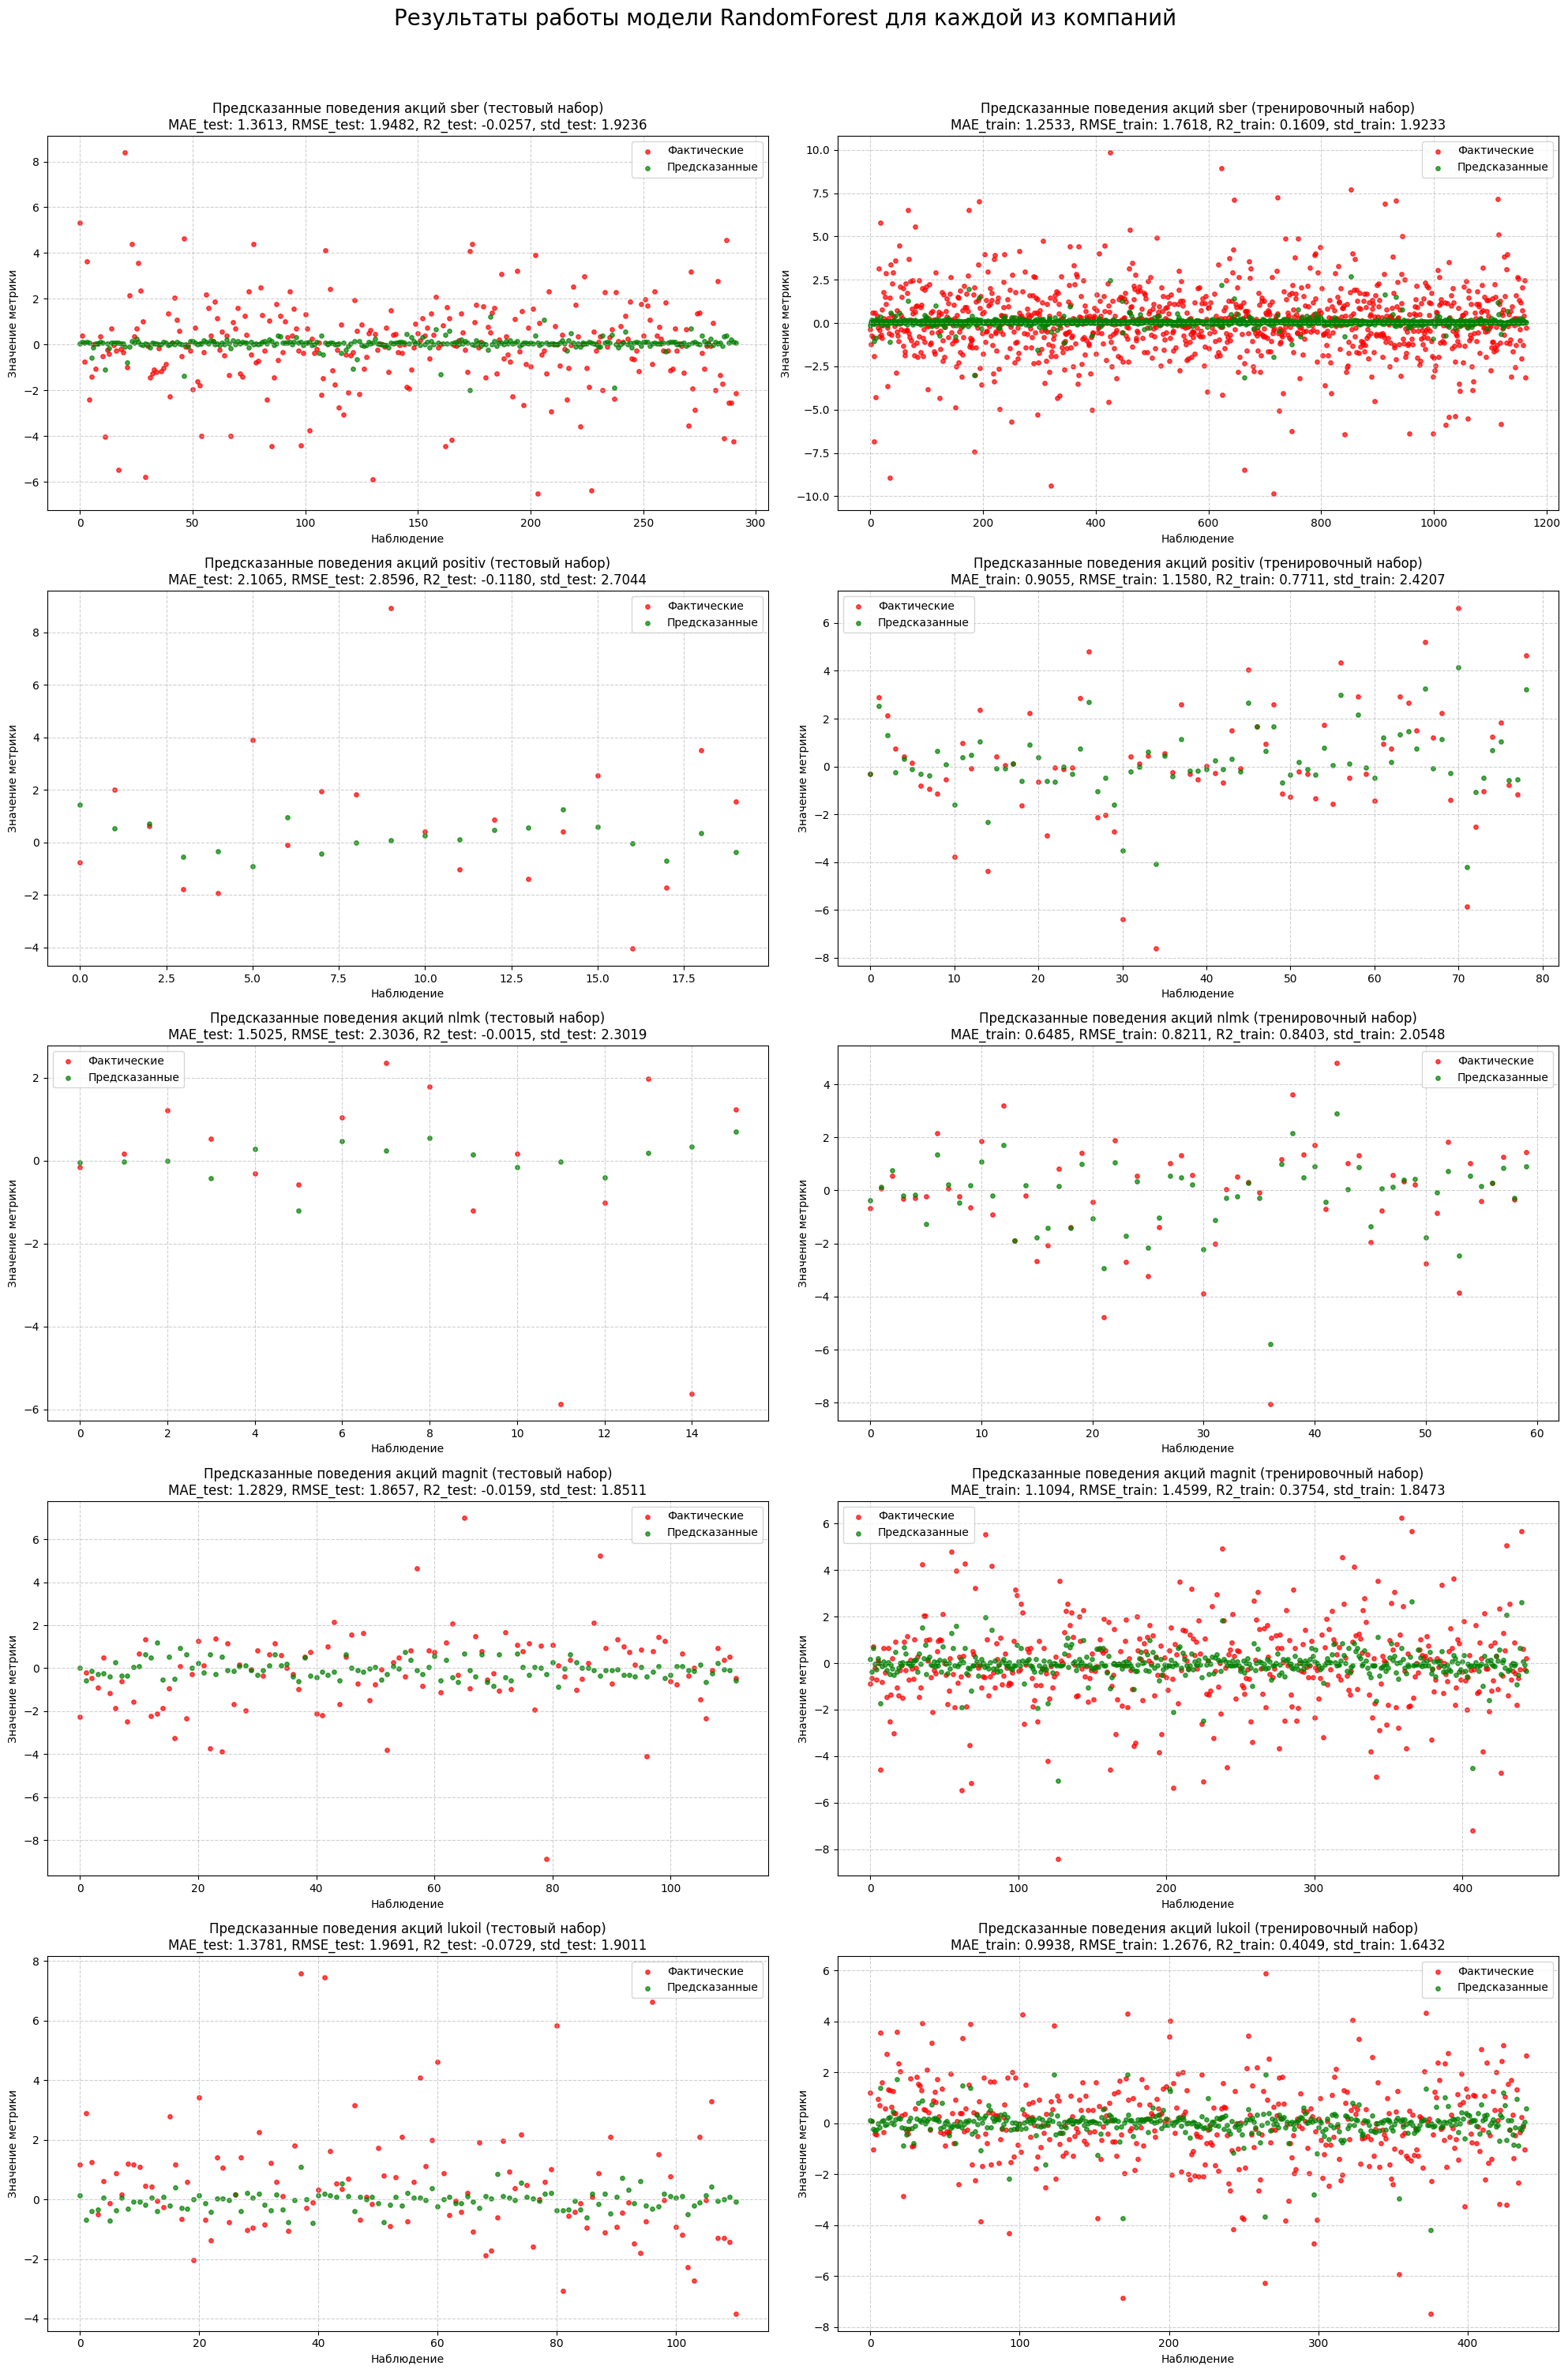

In [17]:
num_companies = len(rf_results)
fig, axes = plt.subplots(num_companies, 2, figsize=(20, 6 * num_companies), squeeze=False)
fig.suptitle('Результаты работы модели RandomForest для каждой из компаний', fontsize=20, y=1.00)

for i in range(num_companies):
    res = rf_results[i]
    company_name = res['company']

    axes[i, 0].scatter(x=res['observation_test'], y=res['y_test'], label="Фактические", color="red", alpha=0.7, s=15)
    axes[i, 0].scatter(x=res['observation_test'], y=res['y_pred_company_test'], label="Предсказанные", color="green", alpha=0.7, s=15)

    title_test = (f"Предсказанные поведения акций {company_name} (тестовый набор)\n"
                  f"MAE_test: {res['mae_test']:.4f}, RMSE_test: {res['rmse_test']:.4f}, R2_test: {res['r2_test']:.4f}, std_test: {res['std_test']:.4f}")
    axes[i, 0].set_title(title_test)

    axes[i, 0].set_ylabel("Значение метрики")
    axes[i, 0].set_xlabel("Наблюдение")
    axes[i, 0].legend()
    axes[i, 0].grid(True, linestyle='--', alpha=0.6)

    axes[i, 1].scatter(x=res['observation_train'], y=res['y_train'], label="Фактические", color="red", alpha=0.7, s=15)
    axes[i, 1].scatter(x=res['observation_train'], y=res['y_pred_company_train'], label="Предсказанные", color="green", alpha=0.7, s=15)

    title_train = (f"Предсказанные поведения акций {company_name} (тренировочный набор)\n"
                   f"MAE_train: {res['mae_train']:.4f}, RMSE_train: {res['rmse_train']:.4f}, R2_train: {res['r2_train']:.4f}, std_train: {res['std_train']:.4f}")
    axes[i, 1].set_title(title_train)

    axes[i, 1].set_ylabel("Значение метрики")
    axes[i, 1].set_xlabel("Наблюдение")
    axes[i, 1].legend()
    axes[i, 1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

**Глядя на графики становится понятно, что модель не может точно предсказывать изменения логарифмических доходностей на основе новостного сентимента**